In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch


train_data_path = '/content/drive/MyDrive/dataset/archive/train'
test_data_path = '/content/drive/MyDrive/dataset/archive/test'
save_model_path = '/content/drive/MyDrive/models'

os.makedirs(save_model_path, exist_ok=True)

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root=train_data_path, transform=transform)
test_dataset = ImageFolder(root=test_data_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [3]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(train_dataset.classes)
)
model.train()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, save_path='checkpoint.pth'):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
            print(f"Model improved. Saved to {self.save_path}.")
        else:
            self.counter += 1
            print(f"Early stopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [5]:
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [6]:
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, epochs, patience, save_path):
    early_stopping = EarlyStopping(patience=patience, save_path=save_path)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = calculate_accuracy(model, train_loader, device)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

        test_loss = test_running_loss / len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = calculate_accuracy(model, test_loader, device)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss {train_loss:.4f}, Test Loss {test_loss:.4f}, Train Acc {train_accuracy:.4f}, Test Acc {test_accuracy:.4f}")

        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    return train_losses, test_losses, train_accuracies, test_accuracies

epochs = 20
patience = 3
save_path = os.path.join(save_model_path, 'vit_best_model.pth')

train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, optimizer, criterion, device, epochs, patience, save_path
)


Epoch 1/20: 100%|██████████| 198/198 [23:22<00:00,  7.08s/it]


Epoch 1/20: Train Loss 0.4256, Test Loss 0.3696, Train Acc 0.9195, Test Acc 0.8846
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 2/20: 100%|██████████| 198/198 [02:42<00:00,  1.21it/s]


Epoch 2/20: Train Loss 0.2135, Test Loss 0.3318, Train Acc 0.9474, Test Acc 0.8807
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 3/20: 100%|██████████| 198/198 [02:43<00:00,  1.21it/s]


Epoch 3/20: Train Loss 0.1787, Test Loss 0.2154, Train Acc 0.9532, Test Acc 0.9364
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 4/20: 100%|██████████| 198/198 [02:43<00:00,  1.21it/s]


Epoch 4/20: Train Loss 0.1623, Test Loss 0.3355, Train Acc 0.9545, Test Acc 0.8794
Early stopping counter: 1 / 3


Epoch 5/20: 100%|██████████| 198/198 [02:42<00:00,  1.22it/s]


Epoch 5/20: Train Loss 0.1379, Test Loss 0.2298, Train Acc 0.9606, Test Acc 0.9248
Early stopping counter: 2 / 3


Epoch 6/20: 100%|██████████| 198/198 [02:42<00:00,  1.22it/s]


Epoch 6/20: Train Loss 0.1268, Test Loss 0.2035, Train Acc 0.9644, Test Acc 0.9326
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 7/20: 100%|██████████| 198/198 [02:43<00:00,  1.21it/s]


Epoch 7/20: Train Loss 0.1246, Test Loss 0.3023, Train Acc 0.9603, Test Acc 0.9014
Early stopping counter: 1 / 3


Epoch 8/20: 100%|██████████| 198/198 [02:42<00:00,  1.22it/s]


Epoch 8/20: Train Loss 0.1130, Test Loss 0.2969, Train Acc 0.9649, Test Acc 0.9053
Early stopping counter: 2 / 3


Epoch 9/20: 100%|██████████| 198/198 [02:44<00:00,  1.21it/s]


Epoch 9/20: Train Loss 0.1067, Test Loss 0.2035, Train Acc 0.9695, Test Acc 0.9287
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 10/20: 100%|██████████| 198/198 [02:45<00:00,  1.20it/s]


Epoch 10/20: Train Loss 0.1005, Test Loss 0.1993, Train Acc 0.9646, Test Acc 0.9222
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 11/20: 100%|██████████| 198/198 [02:45<00:00,  1.19it/s]


Epoch 11/20: Train Loss 0.0927, Test Loss 0.1861, Train Acc 0.9723, Test Acc 0.9416
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 12/20: 100%|██████████| 198/198 [02:45<00:00,  1.20it/s]


Epoch 12/20: Train Loss 0.0974, Test Loss 0.2350, Train Acc 0.9701, Test Acc 0.9209
Early stopping counter: 1 / 3


Epoch 13/20: 100%|██████████| 198/198 [02:45<00:00,  1.20it/s]


Epoch 13/20: Train Loss 0.0960, Test Loss 0.1736, Train Acc 0.9704, Test Acc 0.9533
Model improved. Saved to /content/drive/MyDrive/models/vit_best_model.pth.


Epoch 14/20: 100%|██████████| 198/198 [02:46<00:00,  1.19it/s]


Epoch 14/20: Train Loss 0.0895, Test Loss 0.1904, Train Acc 0.9747, Test Acc 0.9157
Early stopping counter: 1 / 3


Epoch 15/20: 100%|██████████| 198/198 [02:46<00:00,  1.19it/s]


Epoch 15/20: Train Loss 0.0943, Test Loss 0.1994, Train Acc 0.9671, Test Acc 0.9300
Early stopping counter: 2 / 3


Epoch 16/20: 100%|██████████| 198/198 [02:45<00:00,  1.19it/s]


Epoch 16/20: Train Loss 0.0829, Test Loss 0.1893, Train Acc 0.9652, Test Acc 0.9326
Early stopping counter: 3 / 3
Early stopping triggered. Stopping training.


In [7]:
model.load_state_dict(torch.load(save_path))
print("Best model loaded.")


<ipython-input-7-60d20725e4ab>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Best model loaded.


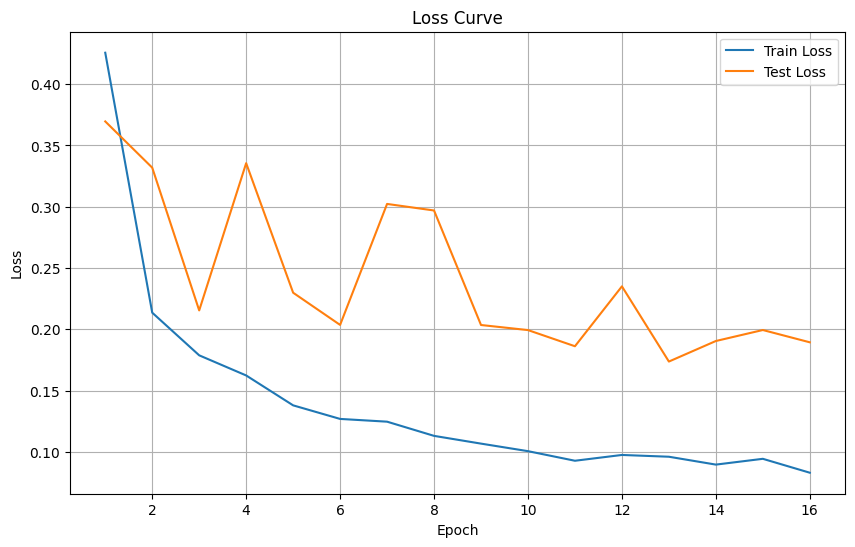

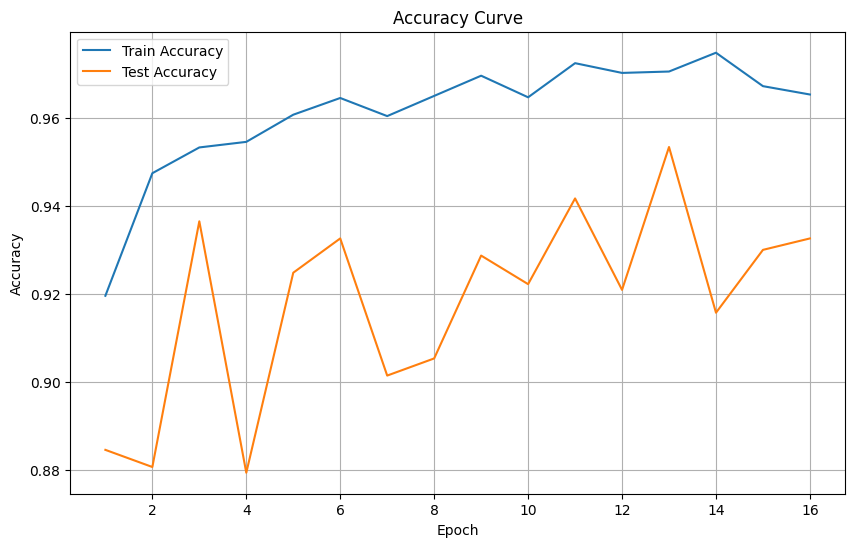

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()


Evaluating: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


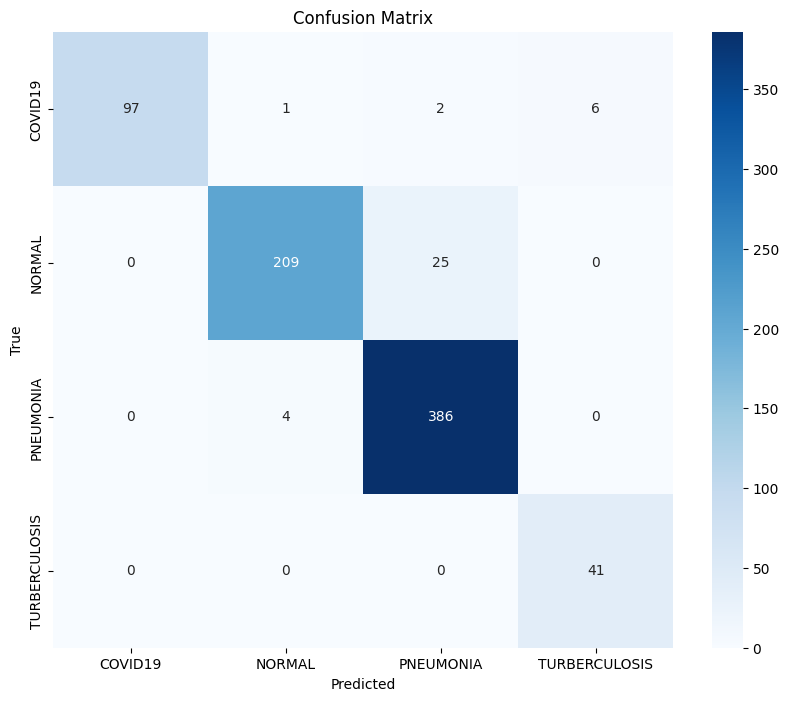

               precision    recall  f1-score   support

      COVID19       1.00      0.92      0.96       106
       NORMAL       0.98      0.89      0.93       234
    PNEUMONIA       0.93      0.99      0.96       390
TURBERCULOSIS       0.87      1.00      0.93        41

     accuracy                           0.95       771
    macro avg       0.95      0.95      0.95       771
 weighted avg       0.95      0.95      0.95       771



In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(model, data_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return report

class_names = train_dataset.classes
report = evaluate(model, test_loader, device, class_names)
print(report)
